In [1]:
%%capture
cd ..

In [2]:

from model import Matuszynska2016

In [65]:
from modelbase2 import Simulator, make_protocol, plot
import itertools as it
from typing import cast
from tqdm.notebook import tqdm
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np

In [4]:
Matuszynska2016().get_stoichiometries()

,v_PSII,v_PQ,v_ATPsynth,v_Leak,v_ATPcons,v_ATPact,v_Xcyc,v_PsbSP
PQH_2,1.00,-1.00,0.000000,0.00,0.0,0.0,0.0,0.0
H_lu,0.02,0.04,-0.046667,-0.01,0.0,0.0,0.0,0.0
ATP_st,0.00,0.00,1.000000,0.00,-1.0,0.0,0.0,0.0
ATPase_ac,0.00,0.00,0.000000,0.00,0.0,1.0,0.0,0.0
Vx,0.00,0.00,0.000000,0.00,0.0,0.0,-1.0,0.0
psbS,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,-1.0


In [5]:
def pam2(
    s: Simulator,
    t_relax: float, #Duration of relaxtion
    t_pulse: float, #Duration of Pulse
    numpeaks_phase0: float,
    numpeaks_phase1: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    max_duration: float = 2500,
):
    step_duration = t_relax + t_pulse
    max_steps = int(max_duration // step_duration) + 1
    
    pfds = list(
        [pfd_dark, pfd_pulse] * numpeaks_phase0 + [pfd_illumination, pfd_pulse] * numpeaks_phase1 + [pfd_dark, pfd_pulse] * (max_steps - (numpeaks_phase0 + numpeaks_phase1))
        
    )
    time_points = list(it.chain.from_iterable((t_relax, t_pulse) for i in range(max_steps)))
    
    ptrc = [
        (t_end, {'pfd': pfd}) for t_end, pfd in zip(time_points, pfds)
    ]
    
    pam_ptrc = make_protocol(ptrc)
    
    s.simulate_over_protocol(pam_ptrc, 100)
    
    return s, pam_ptrc

def npq2(
    s: Simulator,
    peak_distance: float
):
    
    fluo_results = s.get_full_concs()['Fluo'] / max(s.get_full_concs()['Fluo'])
    
    # Find the Flourescence peaks (Fmaxs)
    peaks, _ = find_peaks(fluo_results, distance=peak_distance, height=0)
    
    # Get time at peaks
    time = s.get_full_concs().iloc[peaks].index
    
    # Calculate Fm
    Fm = fluo_results.iloc[peaks].values
    
    #Calculate NPQ
    NPQ = (Fm[0] - Fm) / Fm
    
    # Find the minima around the peaks
    prominences, prominences_left, prominences_right = peak_prominences(
                (fluo_results), peaks
            )  
    
    # Fo is always the minima before the peak
    Fo = s.get_full_concs()['Fluo'].iloc[prominences_left].values
    
    return time, Fm, NPQ, Fo

In [6]:
def create_pam_protocol(
    phase_intervals: list,
    light_phases: list,
    SP_pfd = 5000,
    SP_duration = 0.8,
):
    protocol = []
    for i in range(len(phase_intervals)):
        for relax_time in phase_intervals[i]:
            protocol.append((SP_duration, {"pfd": SP_pfd}))
            protocol.append((relax_time - SP_duration, {"pfd": light_phases[i]}))
            
    return protocol

def phase_intervals_linear(
    phase_duration,
    step,
    first_interval = 0,
    num_steps = None,
    last_intervall = None
):
    phase = []
    accumulated_time = 0
    current_time = first_interval
    
    while accumulated_time < phase_duration and (num_steps is None or len(phase) < num_steps):
        accumulated_time += current_time
        if accumulated_time < phase_duration:
            phase.append(current_time)
        current_time = step * len(phase) + first_interval
        
    if last_intervall is not None:
        phase.append(phase_duration - last_intervall - sum(phase))
        phase.append(last_intervall)
    
    return phase


In [7]:
phase_1 = [30]
phase_two = phase_intervals_linear(14*60, 20, 30)
phase_four = phase_intervals_linear(5*60, 20, 30)


In [8]:
phase_three = phase_intervals_linear(15*60, 20, 30, num_steps=1, last_intervall=None)

pam_protocol1 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        220.003,
        0,
        220.003
    ]
)

pam_protocol1 = make_protocol(pam_protocol1)

s1 = Simulator(Matuszynska2016())
s1.integrator.atol=1e-2
s1.integrator.rtol=1e-2
s1.simulate_over_protocol(pam_protocol1);

In [9]:
phase_three = phase_intervals_linear(30*60, 20, 30, num_steps=1, last_intervall=30)
# print(sum(phase_three), 30*60)

pam_protocol2 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        320.007,
        0,
        320.007
    ]
)

pam_protocol2 = make_protocol(pam_protocol2)

s2 = Simulator(Matuszynska2016())
s2.integrator.atol=1e-2
s2.integrator.rtol=1e-2
s2.simulate_over_protocol(pam_protocol2);

In [10]:
phase_three = phase_intervals_linear(60*60, 20, 30, num_steps=1, last_intervall=30)

pam_protocol3 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        900.003,
        0,
        900.003
    ]
)

pam_protocol3 = make_protocol(pam_protocol3)

s3 = Simulator(Matuszynska2016())
s3.integrator.atol=1e-2
s3.integrator.rtol=1e-2
s3.simulate_over_protocol(pam_protocol3);

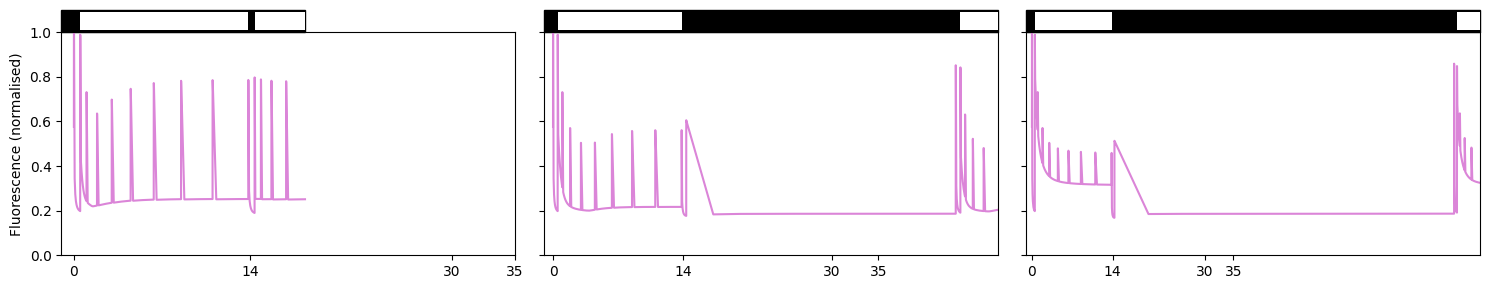

In [13]:
res = [
    {'sim': s1, 'protocol': pam_protocol1},
    {'sim': s2, 'protocol': pam_protocol2},
    {'sim': s3, 'protocol': pam_protocol3},
]

fig, axs = plt.subplots(ncols=3, figsize=(15, 3), sharey=True)

for i in range(len(axs)):
    ax = axs[i]
    c = res[i]['sim'].get_full_results()
    pam_protocol = res[i]['protocol']

    ax.plot(c["Fluo"] / max(c["Fluo"]), color="#db85d8")
    # ax.plot(time, NPQ, linestyle="dashed", color="black", label="NPQ", lw=2)
    pam_ptrc_cleaned = pam_protocol[pam_protocol['pfd'] != 5000]
    
    t0 = pd.Timedelta(seconds=-60)
    
    ax.add_patch(Rectangle(
            (t0.total_seconds(), 1),
            width=pam_ptrc_cleaned['pfd'].index[-1].total_seconds() + 60,
            height=0.1,
            facecolor = 'black',
            edgecolor = 'black',
            lw = 1,
            clip_on=False
        ))
    
    for t_end, val in pam_ptrc_cleaned['pfd'].items():
        t_end = cast(pd.Timedelta, t_end)
        if val == 0:
            color = 'black'
        else:
            color = 'white'
        ax.add_patch(Rectangle(
            (t0.total_seconds(), 1.01),
            width=t_end.total_seconds() - t0.total_seconds(),
            height=0.08,
            facecolor = color,
            clip_on=False
        ))

        t0 = t_end  # type: ignore

    ax.set_xlim(-60, c.index[-1])
    ax.set_ylim(0, 1.0)
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/60:.1f}"))
    ticks_to_show = [0, 14, 30, 35]
    ax.set_xticks([i * 60 for i in ticks_to_show], ticks_to_show)

axs[0].set(
    ylabel="Fluorescence (normalised)",
)

plt.tight_layout()
plt.show()

In [79]:
import sqlite3

cnx = sqlite3.connect('paper_figures/paperdata_new.db')

cur = cnx.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
print(table_list)

df = pd.read_sql_query("select * from LIGHTMEMORY", cnx)
columns_to_keep = ['ExpId', 'Fm', 'Specie', 'LightIntensity', 'DarkDuration', 'Time', 'Replicate']

df = df.drop(columns=[i for i in df.columns if i not in columns_to_keep])
df_arabi = df[df.Specie == "Arabidopsis"]
df_arabi_100 = df_arabi[df_arabi.LightIntensity == 100]
df_arabi_100_15 = df_arabi_100[df_arabi_100.DarkDuration == 15]
df_arabi_100_15.loc[:, 'Time'] = pd.to_timedelta(df_arabi_100_15['Time'])
# df_arabi_100_15.loc[:, 'Time_sec'] = np.nan

# df_arabi_100_15.loc[df_arabi_100_15["Replicate"] == 1, 'Time_sec'] = (df_arabi_100_15[df_arabi_100_15["Replicate"] == 1]['Time'] - df_arabi_100_15[df_arabi_100_15["Replicate"] == 1]['Time'].iloc[0])

# df_arabi_100_15

[('LIGHTMEMORY',), ('sqlite_sequence',)]
